# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install imbalanced-learn

In [2]:
!pip install scikit-learn==0.24.1

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
from workspace import active_session

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pylab import *

from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE, SMOTENC,SMOTEN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

with open('selected_columns.pkl', 'rb') as f:
    selected_columns = pickle.load(f)

# magic word for producing visualizations in notebook
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', 370)
pd.set_option('display.max_rows', 500)

# Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [5]:
%%time
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train_LNR_RESPONSE = mailout_train[['LNR','RESPONSE']]

CPU times: user 1.71 s, sys: 283 ms, total: 1.99 s
Wall time: 2.07 s


<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


In [6]:
with open('azdias_clean.pkl', 'rb') as f:
    azdias_adjusted = pickle.load(f)
    
with open('mailout_train_clean.pkl', 'rb') as f:
    mailout_train_clean = pickle.load(f)
    
with open('mailout_test_clean.pkl', 'rb') as f:
    mailout_test_clean = pickle.load(f)
    
with open('final_columns.pkl', 'rb') as f:
    final_columns = pickle.load(f)
    
with open('pca_62.pkl', 'rb') as f:
    pca_62 = pickle.load(f)
    
with open('kmeans_optimal_model.pkl', 'rb') as f:
    kmeans_optimal_model = pickle.load(f)



In [7]:
%%time
with open('azdias_scaler.pkl', 'rb') as f:
    azdias_scaler = pickle.load(f)
azdias_scaler.fit(azdias_adjusted)

CPU times: user 1.26 s, sys: 15.5 s, total: 16.7 s
Wall time: 42.6 s


In [8]:
%%time
train_scaled = pd.DataFrame(azdias_scaler.transform(mailout_train_clean), columns=final_columns)
test_scaled = pd.DataFrame(azdias_scaler.transform(mailout_test_clean), columns=final_columns)

CPU times: user 153 ms, sys: 83.3 ms, total: 237 ms
Wall time: 334 ms


In [9]:
%%time
train_PCA = pd.DataFrame(pca_62.transform(train_scaled))
test_PCA = pd.DataFrame(pca_62.transform(test_scaled))

CPU times: user 232 ms, sys: 52.4 ms, total: 284 ms
Wall time: 763 ms


## Investigating Clusters vs RESPONSE

In [10]:
plt.rcParams["figure.figsize"] = (16,8)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


CPU times: user 283 ms, sys: 502 ms, total: 785 ms
Wall time: 20.9 s


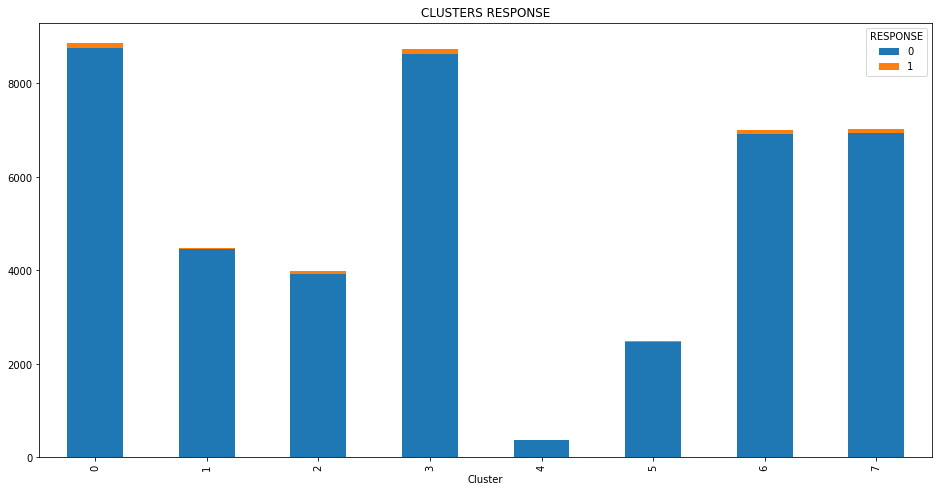

In [11]:
%%time
mailout_train_LNR_RESPONSE['Cluster'] = kmeans_optimal_model.predict(train_PCA)
mailout_train_LNR_RESPONSE.groupby(['Cluster', 'RESPONSE'])['RESPONSE'].count().unstack('RESPONSE').plot(kind='bar', stacked=True, title='CLUSTERS RESPONSE')

## Response: 1 | Cluster Distribution

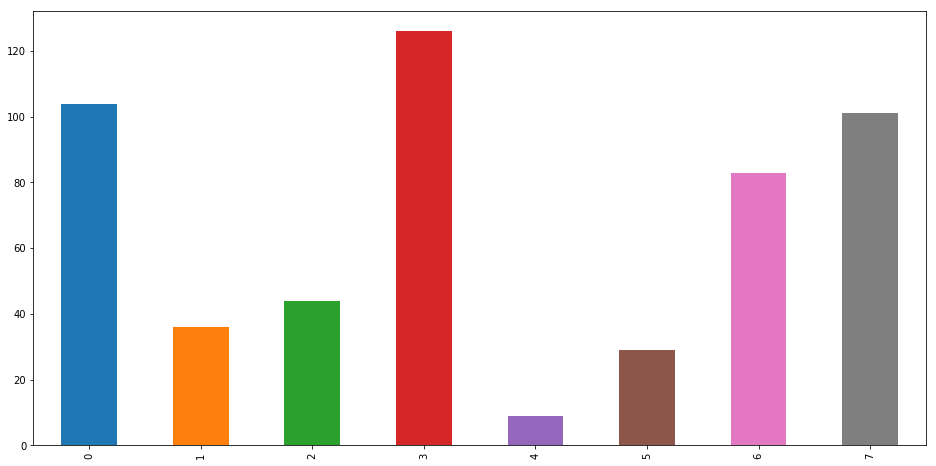

In [12]:
response_1 = mailout_train_LNR_RESPONSE[mailout_train_LNR_RESPONSE['RESPONSE']==1]['Cluster'].value_counts()
response_1.reindex([0,1,2,3,4,5,6,7]).plot(kind='bar')

## Response: 0 | Cluster Distribution

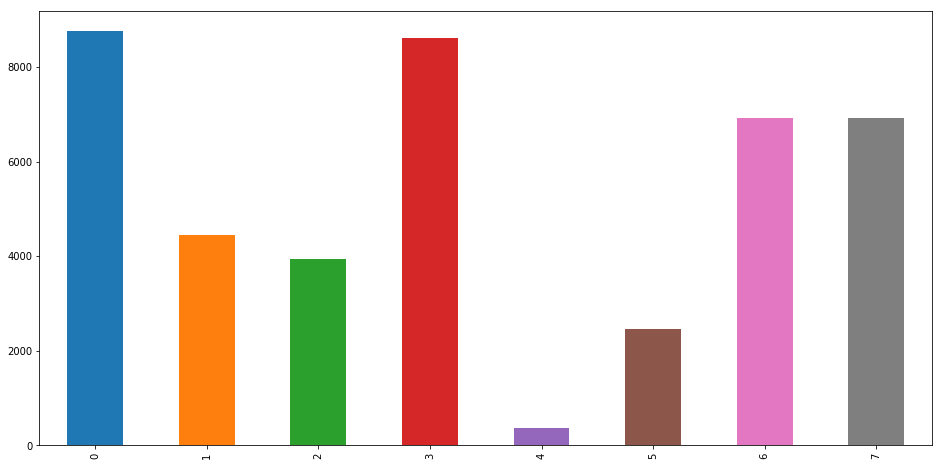

In [13]:
response_2 = mailout_train_LNR_RESPONSE[mailout_train_LNR_RESPONSE['RESPONSE']==0]['Cluster'].value_counts()
response_2.reindex([0,1,2,3,4,5,6,7]).plot(kind='bar')

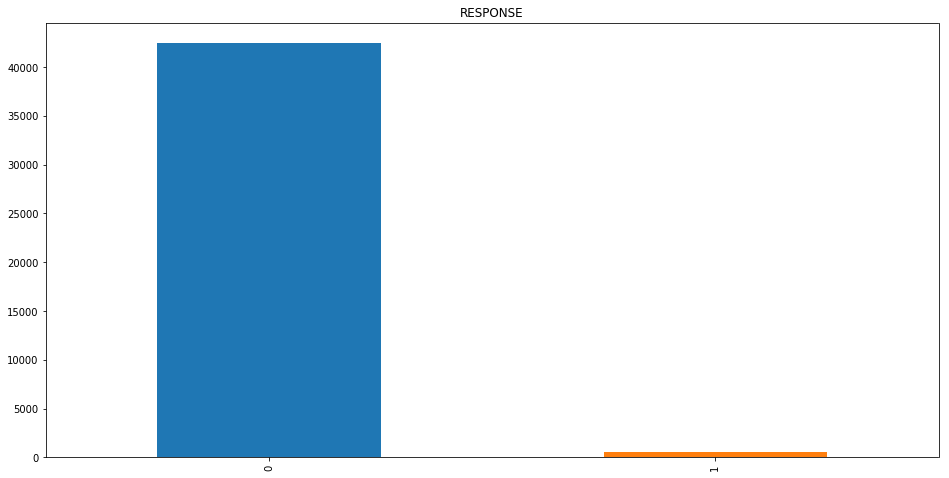

In [14]:
mailout_train_LNR_RESPONSE['RESPONSE'].value_counts().plot(kind='bar', title='RESPONSE')

Apparently we have a highly imbalanced RESPONSE and looking into clusters gave me no clue or insight

## Creating Model

In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor # Adaptive Boosting
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold

In [17]:
def investigate_models(list_of_models,models_names,X,y):
    
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    skf.get_n_splits(X, y)
    model_scores = {}

    for i, clf in enumerate(list_of_models):
        print("_____________________________________")
        print(f"Classifier {i+1}: {models_names[i]}")
        scores = []
        j = 0

        # Perform 5-fold validation
        for train_index, test_index in skf.split(X, y):
            j+=1
            print('Classifier {}: Fold {}...'.format(i+1, j))

            # Split the data into training and test sets
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train using the pipeline
            clf.fit(X_train, y_train)

            #Predict on the test data
            
            y_pred = clf.predict_proba(X_test)[:, 1]

            score = roc_auc_score(y_test, y_pred)
            scores.append(score)
            print(score)

        model_scores[clf] = scores

    scores_df = pd.DataFrame(model_scores)
    scores_df.columns = models_names
    return scores_df

In [18]:
X = train_PCA
y = mailout_train_LNR_RESPONSE['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## COMPARING Classifiers

In [22]:
%%time
models = [AdaBoostClassifier(n_estimators=100),RandomForestClassifier(random_state=42),GradientBoostingClassifier()]
models_names = ['AdaBoostClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']

with active_session():
    score_df = investigate_models(models,models_names,X_train,y_train)

_____________________________________
Classifier 1: AdaBoostClassifier
Classifier 1: Fold 1...
0.48985279710618196
Classifier 1: Fold 2...
0.5648008699400059
Classifier 1: Fold 3...
0.4783542974342715
Classifier 1: Fold 4...
0.5386617984374769
Classifier 1: Fold 5...
0.5176837847344355
_____________________________________
Classifier 2: RandomForestClassifier
Classifier 2: Fold 1...
0.4820995252329875
Classifier 2: Fold 2...
0.5148201909310239
Classifier 2: Fold 3...
0.4928487562731294
Classifier 2: Fold 4...
0.5423092547546977
Classifier 2: Fold 5...
0.44946108235767046
_____________________________________
Classifier 3: GradientBoostingClassifier
Classifier 3: Fold 1...
0.4952272099274034
Classifier 3: Fold 2...
0.5439081906139616
Classifier 3: Fold 3...
0.49280788494597555
Classifier 3: Fold 4...
0.5357983284865719
Classifier 3: Fold 5...
0.5183181749660821
CPU times: user 7min 58s, sys: 347 ms, total: 7min 58s
Wall time: 8min 1s


In [25]:
score_df.describe()

,AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
count,5.000000,5.000000,5.000000
mean,0.517871,0.496308,0.517212
std,0.035289,0.034883,0.023121
min,0.478354,0.449461,0.492808
25%,0.489853,0.482100,0.495227
50%,0.517684,0.492849,0.518318
75%,0.538662,0.514820,0.535798
max,0.564801,0.542309,0.543908


## COMPARING Classifiers - Oversampling with SMOTE

### SMOTE

In [149]:
%%time
with active_session():
    over = SMOTE(sampling_strategy=0.07)
    X_smote, y_smote = over.fit_resample(X_train, y_train)

CPU times: user 56.3 ms, sys: 0 ns, total: 56.3 ms
Wall time: 62.1 ms


In [28]:
%%time
with active_session():
    score_df = investigate_models(models,models_names,X_smote, y_smote)

_____________________________________
Classifier 1: AdaBoostClassifier
Classifier 1: Fold 1...
0.8015321576018446
Classifier 1: Fold 2...
0.8006624457732443
Classifier 1: Fold 3...
0.82071327897034
Classifier 1: Fold 4...
0.8060373762094197
Classifier 1: Fold 5...
0.8027568329427851
_____________________________________
Classifier 2: RandomForestClassifier
Classifier 2: Fold 1...
0.9177754676467457
Classifier 2: Fold 2...
0.9207200202405416
Classifier 2: Fold 3...
0.9201940892629784
Classifier 2: Fold 4...
0.921306904034124
Classifier 2: Fold 5...
0.9051636587021248
_____________________________________
Classifier 3: GradientBoostingClassifier
Classifier 3: Fold 1...
0.8248572231702151
Classifier 3: Fold 2...
0.817770331562286
Classifier 3: Fold 3...
0.8557276210905956
Classifier 3: Fold 4...
0.841561061762768
Classifier 3: Fold 5...
0.8184232461246551
CPU times: user 7min 11s, sys: 65.3 ms, total: 7min 12s
Wall time: 7min 14s


In [29]:
score_df.describe()

,AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
count,5.000000,5.000000,5.000000
mean,0.806340,0.917032,0.831668
std,0.008290,0.006769,0.016520
min,0.800662,0.905164,0.817770
25%,0.801532,0.917775,0.818423
50%,0.802757,0.920194,0.824857
75%,0.806037,0.920720,0.841561
max,0.820713,0.921307,0.855728


In [18]:
%%time
with active_session():
    param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 120],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [10,15],
    'n_estimators': [200,500,1000],
    'criterion': ['entropy', 'gini']
    }
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid,cv = 2, n_jobs = -1, verbose = 2)
    grid_search.fit(X_smote, y_smote)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] END bootstrap=True, criterion=entropy, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  29.0s
[CV] END bootstrap=True, criterion=entropy, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  29.8s
[CV] END bootstrap=True, criterion=entropy, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, criterion=entropy, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, criterion=entropy, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 2.4min
[CV] END bootstrap=True, criterion=entropy, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 2.5min
[

[CV] END bootstrap=True, criterion=gini, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 1.3min
[CV] END bootstrap=True, criterion=gini, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 1.5min
[CV] END bootstrap=True, criterion=gini, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=200; total time=  15.4s
[CV] END bootstrap=True, criterion=gini, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=200; total time=  18.7s
[CV] END bootstrap=True, criterion=gini, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=500; total time=  38.9s
[CV] END bootstrap=True, criterion=gini, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=500; total time=  46.8s
[CV] END bootstrap=True, criterion=gini, max_depth=80, max_features=sqrt, min_sa

In [19]:
best_params_rf = grid_search.best_params_
best_params_rf

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 120,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

## Classifiers & Regressors Models

## Default Data

In [18]:
%%time
rf = RandomForestClassifier(n_estimators=1000, random_state=42, max_features=None)

with active_session():
    rf.fit(X_smote, y_smote)
    with open('rf_model.pkl', 'wb') as f:
        pickle.dump(rf, f)
    print("Model Created and Saved")

Model Created and Saved
CPU times: user 35min 27s, sys: 1.86 s, total: 35min 29s
Wall time: 35min 37s


## Oversampling and Undersampling

In [21]:
%%time
from imblearn.under_sampling import RandomUnderSampler,NearMiss
    
smote = SMOTE(sampling_strategy=0.05,random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

nm = NearMiss(version=1,n_neighbors=3,sampling_strategy=0.07)
X_rs, y_rs = nm.fit_resample(X_smote, y_smote)

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size=0.33, random_state=42)

CPU times: user 1.42 s, sys: 1.24 s, total: 2.66 s
Wall time: 2.68 s


In [23]:
%%time
rf_2 = RandomForestClassifier(criterion= 'entropy',random_state=42, n_estimators=2000, max_features='sqrt')
with active_session():
    #rf_3.fit(X_rs, y_rs)
    #rf_3.fit(X_train, y_train)
    #rf_3.fit(X_smote, y_smote)
    rf_2.fit(X_train, y_train)
    with open('rf_model_2.pkl', 'wb') as f:
        pickle.dump(rf_2, f)
    print("Model Created and Saved")

Model Created and Saved
CPU times: user 7min 22s, sys: 706 ms, total: 7min 22s
Wall time: 7min 25s


In [25]:
roc3 = roc_auc_score(y_test, rf_2.predict_proba(X_test)[:, 1])
print(f" Model 2: {roc3}")

 Model 2: 0.8981080390702317


In [24]:
roc3 = roc_auc_score(y, rf_2.predict_proba(X)[:, 1])
print(f" Model 2: {roc3}")

 Model 2: 0.9330006166724849


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [27]:
%%time
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

CPU times: user 1.63 s, sys: 124 ms, total: 1.75 s
Wall time: 1.8 s


<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


In [34]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
print(f"Dataset Loaded")
mailout_test_LNR = pd.DataFrame(mailout_test['LNR'].copy(),columns=['LNR'])
X_mail = test_PCA.copy()

Dataset Loaded


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Submission 1:

In [ ]:
submission = pd.DataFrame(index=mailout_test_LNR['LNR'].astype('int32'), data=rf.predict_proba(X_mail)[:,1], columns=['RESPONSE'])
submission.to_csv('submission3.csv')

## Submission 2:

In [ ]:
submission2 = pd.DataFrame(index=mailout_test_LNR['LNR'].astype('int32'), data=rf_2.predict_proba(X_mail)[:,1], columns=['RESPONSE'])
submission2.to_csv('submission2.csv')

In [278]:
submission

,RESPONSE
LNR,
1754,0.256410
1770,0.248004
1465,0.139810
1470,0.311001
1478,0.498806
1782,0.284257
1485,0.447206
1519,0.078810
1835,0.376575


In [37]:
submission2

,RESPONSE
LNR,
1754,0.056040
1770,0.054000
1465,0.055000
1470,0.061511
1478,0.076500
1782,0.056500
1485,0.087500
1519,0.064000
1835,0.088000
